In [6]:
# Import required libraries
import openslide
from openslide.deepzoom import DeepZoomGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

main_dir = "/media/dataanalyticlab/Drive2/MANSOOR/Neuroimaging-Project/WSI_Breast_Cancer_ClassificationProj"
SVS_dir = f"{main_dir}/SVS_Data"
labels_dir = f"{main_dir}/WSI_Breast_Cancer_Classification/Labels"
models_dir = f"{main_dir}/WSI_Breast_Cancer_Classification/Model_Weights"
Tiles_dir = f"{main_dir}/Tiles_Data"


In [7]:
def find_missing_files(labels_path, svs_directory, output_path):
    # Load the labels Excel file
    df = pd.read_excel(labels_path)
    df['ID'] = df['ID'].astype(str)

    # Append '.svs' to IDs to form the filenames
    df['filename'] = df['ID'] + '.svs'

    # Check if each file exists in the specified directory
    df['exists'] = df['filename'].apply(lambda x: os.path.isfile(os.path.join(svs_directory, x)))

    # Filter out entries for missing files
    missing_files_df = df[df['exists'] == False]

    # Display the missing files
    if not missing_files_df.empty:
        print("Missing files:")
        print(missing_files_df[['ID', 'filename']])
    else:
        print("No missing files.")
        # Filter the dataframe to only include rows for existing files
    existing_files_df = df[df['exists'] == True].drop(columns=['exists', 'filename'])

    # Save the filtered DataFrame to a new Excel file
    existing_files_df.loc[:,:"NMYC"].to_excel(output_path, index=False)
    print(f"Filtered labels have been saved to {output_path}")
    print("Filtered Data:")
    print(existing_files_df.head())
    

# Set paths and call the function
labels_file_path = f'{labels_dir}/final_labels_wsi.xlsx'  # Update with the path to your labels file
output_labels_path = f'{labels_dir}/filered_final_labels_wsi.xlsx'

find_missing_files(labels_file_path, SVS_dir, output_labels_path)


Missing files:
              ID          filename
2   DI-MH-694-07  DI-MH-694-07.svs
15  DI-MH-226-12  DI-MH-226-12.svs
17  DI-MH-226-14  DI-MH-226-14.svs
19  DI-MH-226-15  DI-MH-226-15.svs
25  DI-MH-243-09  DI-MH-243-09.svs
26  DI-MH-243-18  DI-MH-243-18.svs
27  DI-MH-694-02  DI-MH-694-02.svs
29  DI-MH-694-03  DI-MH-694-03.svs
Filtered labels have been saved to /media/dataanalyticlab/Drive2/MANSOOR/Neuroimaging-Project/WSI_Breast_Cancer_ClassificationProj/WSI_Breast_Cancer_Classification/Labels/filered_final_labels_wsi.xlsx
Filtered Data:
             ID  F/U NMYC Unnamed: 3
0  DI-MH-694-08  NaN    p        NaN
1  DI-MH-694-09  NaN    p        NaN
3  DI-MH-694-06    F    p        NaN
4  DI-MH-694-05    U    p        NaN
5  DI-MH-226-01    F    n        NaN


Slide dimensions: (59759, 53035)
Number of levels: 4
Level dimensions: ((59759, 53035), (14939, 13258), (3734, 3314), (1867, 1657))
Level downsamples: (1.0, 4.0002135475638845, 16.003668195728046, 32.00733639145609)


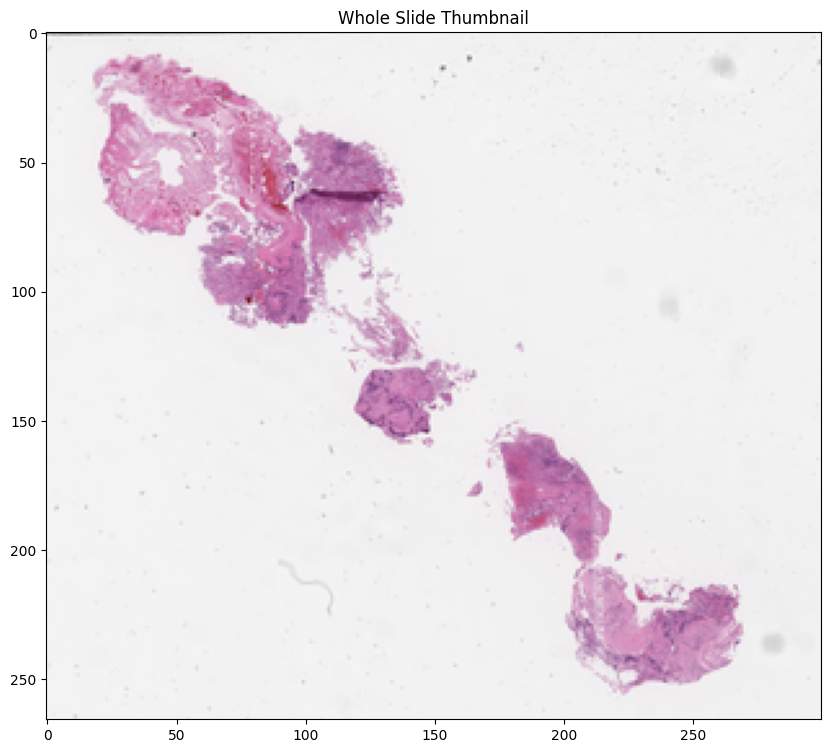

Slide dimensions: (89639, 74238)
Number of levels: 4
Level dimensions: ((89639, 74238), (22409, 18559), (5602, 4639), (2801, 2319))
Level downsamples: (1.0, 4.0001208196047084, 16.00213372275892, 32.00771785903483)


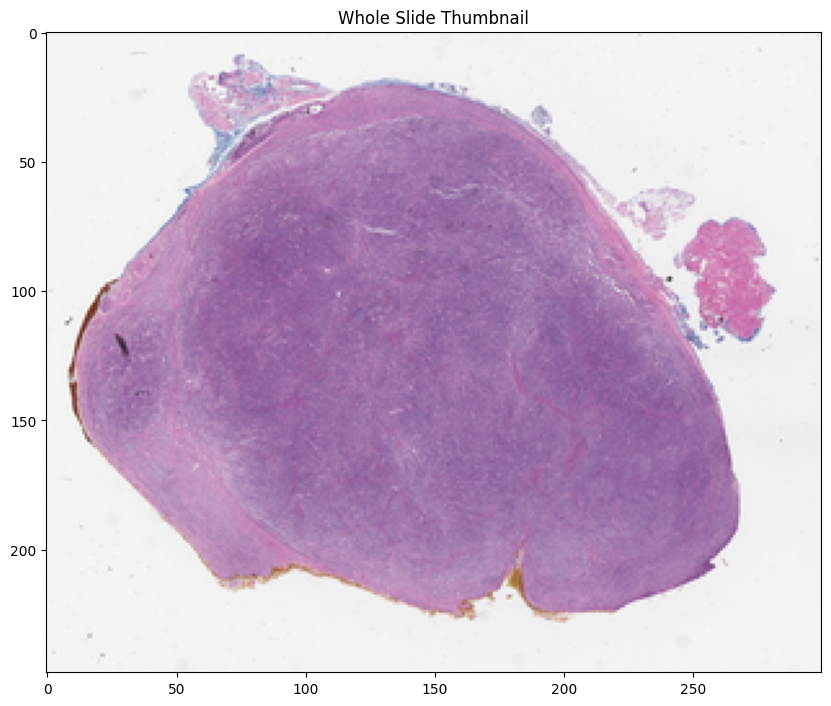

Slide dimensions: (115536, 86868)
Number of levels: 4
Level dimensions: ((115536, 86868), (28884, 21717), (7221, 5429), (3610, 2714))
Level downsamples: (1.0, 4.0, 16.000368391969054, 32.005900664860775)


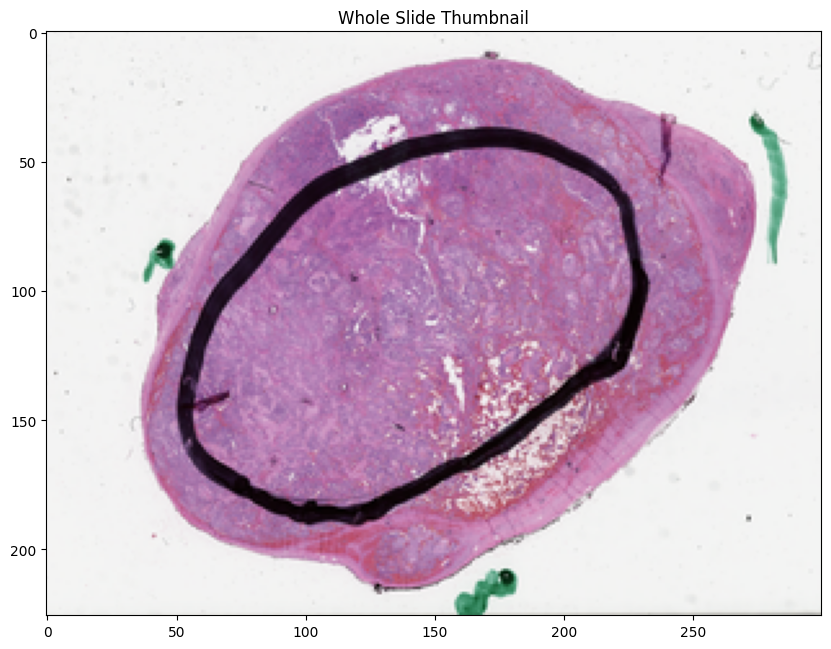

Slide dimensions: (107567, 64022)
Number of levels: 4
Level dimensions: ((107567, 64022), (26891, 16005), (6722, 4001), (3361, 2000))
Level downsamples: (1.0, 4.000118261219338, 16.001865551910146, 32.00773147872657)


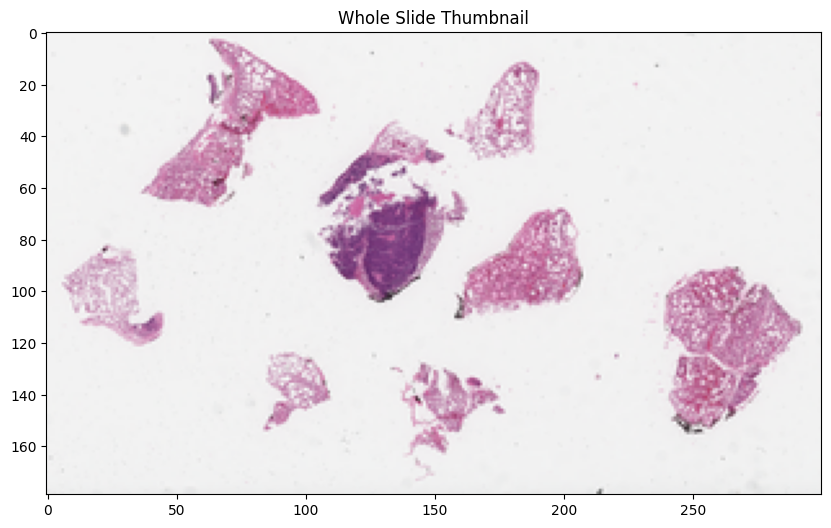

In [8]:
# Function to load an SVS file and show its properties
def load_and_display_info(svs_path):
    slide = openslide.OpenSlide(svs_path)
    print("Slide dimensions:", slide.dimensions)
    print("Number of levels:", slide.level_count)
    print("Level dimensions:", slide.level_dimensions)
    print("Level downsamples:", slide.level_downsamples)
    
    # Display a thumbnail of the whole slide
    plt.figure(figsize=(10, 10))
    plt.imshow(slide.get_thumbnail(size=(300, 300)))
    plt.title("Whole Slide Thumbnail")
    plt.show()
    
    return slide

# Load example slides
svs_file_path = [f"{SVS_dir}/1.svs", f"{SVS_dir}/DI-MH-226-01.svs", f"{SVS_dir}/DI-MH-243-01.svs", 
                 f"{SVS_dir}/DI-MH-694-01.svs"]
for file_path in svs_file_path:
    slide = load_and_display_info(file_path)

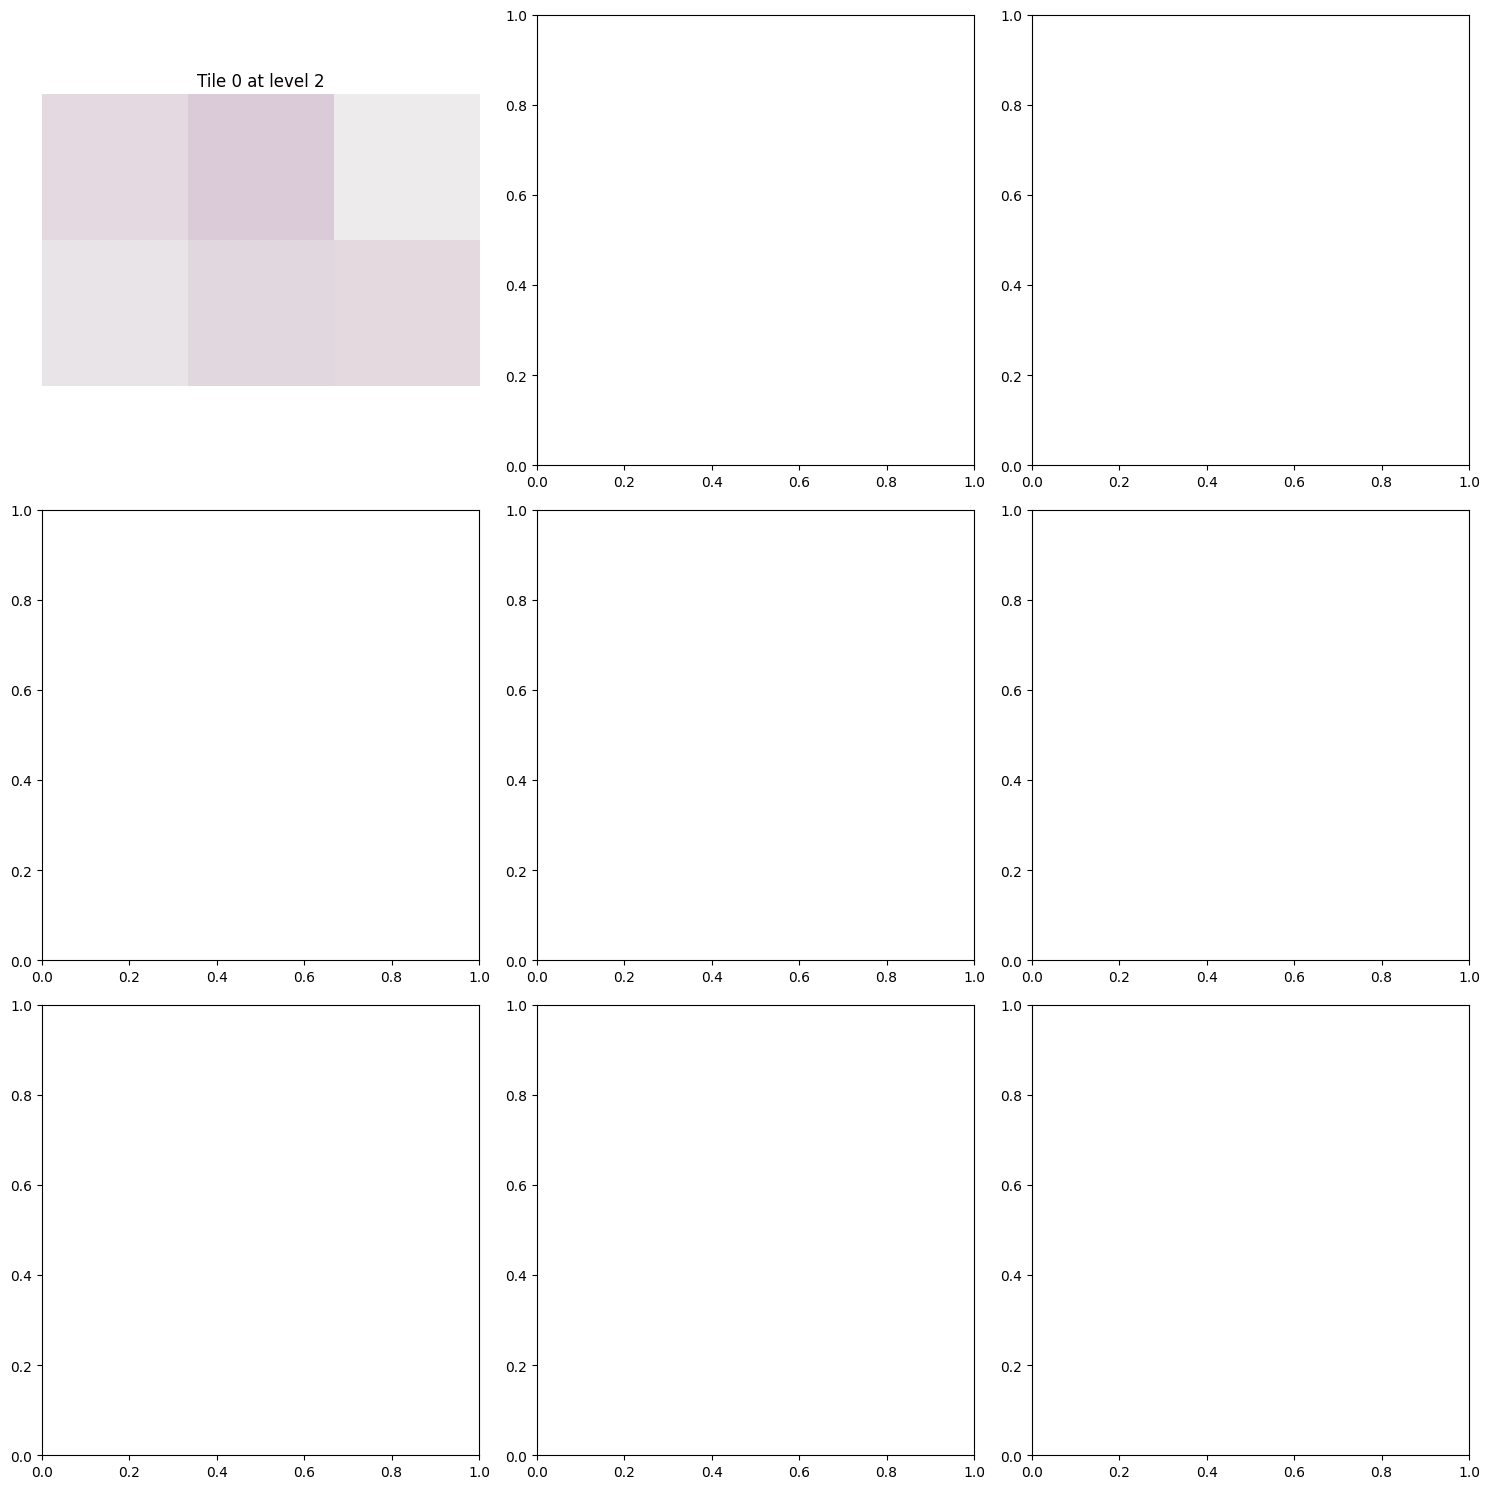

In [10]:

# Function to create a tile generator and extract tiles from a specified level
def create_and_display_tiles(slide, level, tile_size=256):
    dzi = DeepZoomGenerator(slide, tile_size=tile_size, overlap=0, limit_bounds=True)
    cols, rows = dzi.level_tiles[level]
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    
    for i, ax in enumerate(axs.flatten()):
        if i < cols * rows:
            col, row = i % cols, i // cols
            tile = dzi.get_tile(level, (col, row))
            ax.imshow(tile)
            ax.set_title(f"Tile {i} at level {level}")
            ax.axis('off')
        plt.tight_layout()
        
    return dzi

# Create tiles at a specific level and display them
level_to_extract = 2  # choose a suitable level
tile_generator = create_and_display_tiles(slide, level_to_extract)



In [13]:
def load_labels(file_path):
    return pd.read_excel(file_path)

def extract_tiles(svs_path, label, output_dir, tile_size=256, level=None, overlap=0, white_threshold=235):
    try:
        slide = openslide.OpenSlide(svs_path)
        print(f"Slide Levels: {slide.level_count}, Level Dimensions: {slide.level_dimensions}")
        if level is None:
            level = 0  # Default to the highest resolution level
        
        dzi = DeepZoomGenerator(slide, tile_size=tile_size, overlap=overlap, limit_bounds=True)
        cols, rows = dzi.level_tiles[level]
        print(f"Processing {svs_path}: Level {level}, {cols}x{rows} tiles")

        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        tile_count = 0
        for col in range(cols):
            for row in range(rows):
                tile = dzi.get_tile(level, (col, row))
                tile_np = np.array(tile)
                if np.mean(tile_np) < white_threshold and np.std(tile_np) > 20:
                    tile_filename = f"{os.path.splitext(os.path.basename(svs_path))[0]}_tile_{col}_{row}.png"
                    tile.save(os.path.join(label_dir, tile_filename))
                    tile_count += 1

        print(f"Saved {tile_count} tiles from {svs_path}")

    except Exception as e:
        print(f"Error processing {svs_path}: {e}")

def main(labels_file, svs_directory, output_directory, level=None):
    labels_df = load_labels(labels_file)
    
    for _, row in labels_df.iterrows():
        svs_filename = f"{row['ID'].split(' ')[0]}.svs"
        svs_path = os.path.join(svs_directory, svs_filename)
        if os.path.exists(svs_path):
            extract_tiles(svs_path, row['NMYC'], output_directory, level=level)
        else:
            print(f"File not found: {svs_path}")

main(output_labels_path, SVS_dir, Tiles_dir, level=0)  # Specify desired level


Slide Levels: 4, Level Dimensions: ((137448, 74984), (34362, 18746), (8590, 4686), (2147, 1171))
Processing /media/dataanalyticlab/Drive2/MANSOOR/Neuroimaging-Project/WSI_Breast_Cancer_ClassificationProj/SVS_Data/DI-MH-694-08.svs: Level 0, 1x1 tiles
Saved 0 tiles from /media/dataanalyticlab/Drive2/MANSOOR/Neuroimaging-Project/WSI_Breast_Cancer_ClassificationProj/SVS_Data/DI-MH-694-08.svs
Slide Levels: 4, Level Dimensions: ((135456, 60870), (33864, 15217), (8466, 3804), (2116, 951))
Processing /media/dataanalyticlab/Drive2/MANSOOR/Neuroimaging-Project/WSI_Breast_Cancer_ClassificationProj/SVS_Data/DI-MH-694-09.svs: Level 0, 1x1 tiles
Saved 0 tiles from /media/dataanalyticlab/Drive2/MANSOOR/Neuroimaging-Project/WSI_Breast_Cancer_ClassificationProj/SVS_Data/DI-MH-694-09.svs
Slide Levels: 4, Level Dimensions: ((51791, 56509), (12947, 14127), (3236, 3531), (1618, 1765))
Processing /media/dataanalyticlab/Drive2/MANSOOR/Neuroimaging-Project/WSI_Breast_Cancer_ClassificationProj/SVS_Data/DI-MH-6